Calculating the streamfunction, sanity check!

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram
from collections import OrderedDict

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39363/status,
Dashboard: /proxy/39363/status,Workers: 8
Total threads: 8,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33467,Workers: 8
Dashboard: /proxy/39363/status,Total threads: 8
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:40917,Total threads: 1
Dashboard: /proxy/33943/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:35423,


In [5]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [6]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)

# cc.querying.get_variables(session, experiment='1deg_jra55_ryf_cont')

In [8]:
expt = '1deg_jra55_ryf_cont'
var = 'ty_trans_rho_gm'
yr_beg = '2400-01-02'
yr_end = '2425-12-31'
control_streamfunction = (cc.querying.getvar(expt, 'ty_trans_rho', session, start_time = yr_beg, end_time = yr_end) \
+ cc.querying.getvar(expt, 'ty_trans_rho_gm', session, start_time = yr_beg, end_time = yr_end)).sel(grid_xt_ocean = slice(- 103, - 5)).sum('grid_xt_ocean').mean(dim='time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

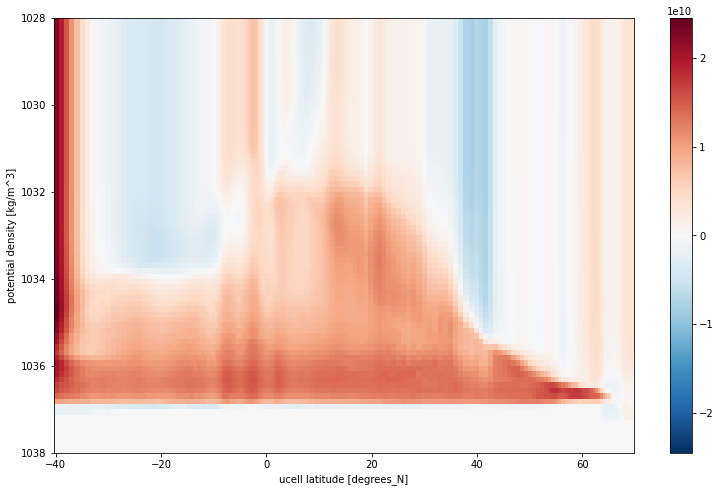

In [12]:
plt.figure(figsize=(13,8))
test = control_streamfunction.load()
test = test.cumsum('potrho') - test.sum('potrho')
test = test.sel(grid_yu_ocean=slice(-40,70))
test.plot()
plt.gca().invert_yaxis()

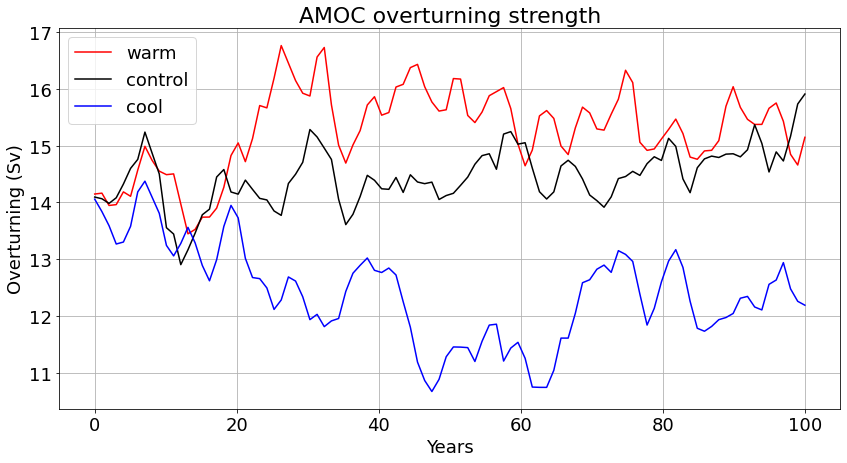

In [65]:
keys = ['warm', 'control', 'cool']
colors = {'warm': 'r','control': 'k','cool':'b'}
linestyles = {'warm': '-','control': '-','cool':'-'}
yr_beg = '2400-01-01'
yr_end = '2499-12-31'

amocs = []

plt.figure(figsize=(14, 7))

for ekey in exptdict:
    expt = exptdict[ekey]['expt']
    
    var = xr.open_mfdataset(paths=f'/scratch/e14/mp2135/access-om2/archive/{expt}/output1*/ocean/ocean-3d-ty_trans_rho-1-monthly-mean-ym*', combine='by_coords').ty_trans_rho.sel(time=slice(yr_beg, yr_end))
    psi_amoc = var.sel(grid_xt_ocean = slice(- 103, - 5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26) * 1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = xr.open_mfdataset(paths=f'/scratch/e14/mp2135/access-om2/archive/{expt}/output1*/ocean/ocean-3d-ty_trans_rho_gm-1-monthly-mean-ym*', combine='by_coords').ty_trans_rho_gm.sel(time=slice(yr_beg, yr_end))
        psi_amoc_gm = var2.sel(grid_xt_ocean = slice( - 103, - 5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26) * 1.0e-9
        psi_amoc_gm_sum = psi_amoc_gm.cumsum('potrho') - psi_amoc_gm.sum('potrho')
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm_sum
        #psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean().dropna('time').load()
    
    amocs.append(psi_amoc_sum)
    
    # psi_amoc_sum.plot(label = ekey, color = colors[ekey], linestyle = linestyles[ekey])
    plt.plot(np.linspace(0,100,psi_amoc_sum.time.shape[0]), psi_amoc_sum, label = ekey, color = colors[ekey], linestyle = linestyles[ekey])
        
xlims = plt.xlim()
plt.xlabel('Years', fontsize=18)
plt.ylabel('Overturning (Sv)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title('AMOC overturning strength', fontsize=22)
plt.grid()
# plt.savefig('Fig7.pdf', bbox_inches='tight', dpi=300)